In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mylibrary.nnlib as tnn
import copy

## Making Class for Soft But Hard Decision Tree - Dynamic Building/End2End

In [2]:
class LeafNode(object):
    
    def __init__(self, parent, constant=None):
        self.parent = parent
        self.constant = tnn.BiasLayer(self.parent.output_dim,
                                      bias=copy.deepcopy(constant),
                                      optimizer=self.parent.optimizer)
        self.error = 9e9
        self.mask = None
        
    def forward(self, inputs):
        out = np.zeros(shape=(inputs.shape[0], self.parent.output_dim))
        return self.constant.forward(out)
    
    def backward(self, del_outputs):
        self.constant.backward(del_outputs)
        self.error = (del_outputs**2).mean()
        return del_outputs
    
    def update(self):
        self.constant.update()
        
    def get_maximum_error_node(self):
        return self
    
#     def convert_to_decision_node(self):
#         bias = self.constant.bias
#         dn = DecisionNode(self.parent.input_dim, self.parent.output_dim, self.parent.optimizer)
#         dn.node0 = LeafNode(self.parent, bias)
#         dn.node1 = LeafNode(self.parent, bias)
#         return dn
    
    def print_tree(self, depth):
        print(f"{'|     '*depth}Leaf:({depth})")
        return
    
class DecisionNode(object):
    
    def __init__(self, input_dim, output_dim, optimizer):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.optimizer = optimizer
        
        self.node0 = None
        self.node1 = None
        self.linear = tnn.LinearLayer(input_dim, 1, optimizer=optimizer)
        self.linear.weights *= 0

#         self.linear = tnn.AutoForm(new_layers=True)
#         a = tnn.NonLinearLayer(input_dim, 5, activation=tnn.Tanh(), optimizer=optimizer)
#         b = tnn.LinearLayer(5, 1, optimizer=optimizer)
#         self.linear.layerList = [a,b]
        
        self.sigmoid = tnn.Sigmoid()
        
        self.mask = None
        self.out0 = None
        self.out1 = None
        
    def forward(self, inputs):
        lout = self.linear.forward(inputs)
        self.sigmoid.forward(lout)
        
        self.mask = (lout>0).astype(lout.dtype)
        self.out0 = self.node0.forward(inputs)
        self.out1 = self.node1.forward(inputs)
        
        return self.out0*self.mask + self.out1*(1-self.mask)
    
    def backward(self, del_outputs):
        del_out0 = del_outputs*self.mask
        del_out1 = del_outputs*(1-self.mask)
        
        self.node0.backward(del_out0)
        self.node1.backward(del_out1)
        
        self.linear.backward(self.sigmoid.backward(del_outputs.mean(axis=1, keepdims=True)))
        return del_outputs
    
    def update(self):
        self.linear.update()
        self.node0.update()
        self.node1.update()
        
    def create_child(self, depth):
        if depth > 1:
            self.node0 = DecisionNode(self.input_dim, self.output_dim, self.optimizer)
            self.node1 = DecisionNode(self.input_dim, self.output_dim, self.optimizer)
            self.node0.create_child(depth-1)
            self.node1.create_child(depth-1)
        else:
            self.node0 = LeafNode(self)
            self.node1 = LeafNode(self)
            
    def get_maximum_error_node(self):
        n0 = self.node0.get_maximum_error_node()
        n1 = self.node1.get_maximum_error_node()
        if n0.error > n1.error:
            return n0
        else:
            return n1
        
    def print_tree(self, depth=0):
        print(f"{'|     '*depth}DN:({depth})")
        self.node0.print_tree(depth+1)
        self.node1.print_tree(depth+1)

## 1D regression

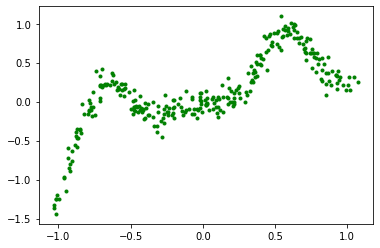

In [3]:
x = np.linspace(0,1,300)
noise = np.random.normal(0,0.02, x.shape)
x = x + noise
x = np.sort(x)

y= (2 * np.sin(10*x) + np.cos(20 * x - 3) + 3 * np.log(10*x + 0.5) - 4)/6.
noise = np.random.normal(0,0.1, x.shape)
y = y + noise

x = x*2
x = x - x.mean() # good practice to zero-center x in linear mapping
xx = x.reshape(-1,1)
yy = y.reshape(-1,1)

%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.show()

In [4]:
def convert_leaf_to_decision_node(node):
    parent = node.parent
    const = copy.deepcopy(node.constant.bias)

    
    dn = DecisionNode(parent.input_dim, parent.output_dim, parent.optimizer)
    dn.node0 = LeafNode(dn, const)
    dn.node1 = LeafNode(dn, const)
    if parent.node0 is node:
        del parent.node0
        parent.node0 = dn
    elif parent.node1 is node:
        del parent.node1
        parent.node1 = dn
    else:
        print(parent.node0, parent.node1, node)
        print("Error occoured -- Problem in Algorithm")
    return

def add_node_to_tree(tree):
    try:
        node = tree.get_maximum_error_node()
        convert_leaf_to_decision_node(node)
    except:
        print("Error occoured while converting leaf node to decision Node")
    return

In [5]:
# optimizer=tnn.Adam()
# hdt = DecisionNode(1,1,optimizer)
# hdt0 = LeafNode(hdt)
# hdt1 = DecisionNode(1,1,optimizer)
# hdt10 = LeafNode(hdt1)
# hdt11 = LeafNode(hdt1)

# hdt.node0 = hdt0
# hdt1.node0 = hdt10
# hdt1.node1 = hdt11
# hdt.node1 = hdt1

In [14]:
optimizer = tnn.Adam()
hdt = DecisionNode(1, 1, optimizer)
hdt.create_child(depth=4)

In [15]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(111)

for epoch in range(100000):
    yout = hdt.forward(xx)
    dy = yout - yy
    dx = hdt.backward(dy)
    hdt.update()
    
    if epoch%100 == 0:
        
        error = (dy**2).mean()
        print(epoch, 'Error = ', error)
        ax.clear()
        ax.scatter(x, y, marker='.', color='g')
        ax.scatter(x, yout.reshape(-1), color='r', marker='.')

        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  0.2224612723483193


100 Error =  0.15085266682410872


200 Error =  0.13059288336128236


300 Error =  0.11652099694204748


400 Error =  0.10689490987922567


500 Error =  0.09557528613293485


600 Error =  0.07866756853868753


700 Error =  0.0683308457675429


800 Error =  0.062085732196725016


900 Error =  0.05881233174675486


1000 Error =  0.056995135160376645


1100 Error =  0.05363109450048519


1200 Error =  0.05384131546993372


1300 Error =  0.05086997112829216


1400 Error =  0.0485393027985302


1500 Error =  0.04736633024754617


1600 Error =  0.04623811898251124


1700 Error =  0.0451829109991086


1800 Error =  0.04843852771628999


1900 Error =  0.044828682399521785


2000 Error =  0.04232759923357913


2100 Error =  0.04116460174747065


2200 Error =  0.04069358335379999


2300 Error =  0.03901908094417507


2400 Error =  0.03950250616586285


2500 Error =  0.03799196789512487


2600 Error =  0.03785201526033249


2700 Error =  0.03679852922762685


2800 

TclError: invalid command name "."

In [12]:
add_node_to_tree(hdt)

In [64]:
hdt.print_tree()

DN:(0)
|     Leaf:(1)
|     DN:(1)
|     |     Leaf:(2)
|     |     Leaf:(2)


## On 2D dataset

In [65]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8)
% matplotlib tk

In [66]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

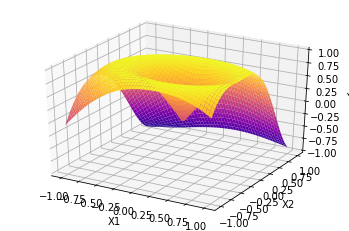

In [67]:
####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.scatter(X1, X2, Y)
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [68]:
xx = np.c_[x1, x2]
yy = Y.reshape(-1,1)

## Building Decision Tree

In [69]:
optimizer = tnn.Adam()
hdt = DecisionNode(2, 1, optimizer)
hdt.create_child(depth=1)

In [79]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')

for epoch in range(100000):

    yout = hdt.forward(xx)
    dy = yout - yy
    dx = hdt.backward(dy)
    hdt.update()
    
    if epoch%100 == 0:
        
        error = (dy**2).mean()
        print(epoch, 'Error = ', error)
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.reshape(-1), color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  0.03473649097006699


100 Error =  0.03666808045039164


200 Error =  0.029305195987054968


300 Error =  0.032914891464954577


400 Error =  0.03357088634715785


500 Error =  0.02717089472237317


600 Error =  0.025967346293042044


700 Error =  0.030200001301958553


800 Error =  0.032407903327881


900 Error =  0.03267104757699997


1000 Error =  0.03996206423467303


1100 Error =  0.03375374448488286


1200 Error =  0.03720089282242764


1300 Error =  0.030873199221289623


1400 Error =  0.035382802580362735


1500 Error =  0.02683379077981465


1600 Error =  0.032070095887441995


1700 Error =  0.027236546160828903


1800 Error =  0.03419019267253502


1900 Error =  0.02590917212910153


2000 Error =  0.017787204685570115


2100 Error =  0.01825450258844907


2200 Error =  0.01835255439070618


2300 Error =  0.018301360673116558


2400 Error =  0.01780844554538321


2500 Error =  0.017151538724695686


2600 Error =  0.01724062649459225


2700 Error =  0.017102597929890

22100 Error =  0.027190479043908478


22200 Error =  0.03179330022899327


22300 Error =  0.03044189260462979


22400 Error =  0.03283709473476898


22500 Error =  0.032420315362310555


22600 Error =  0.028019255971669436


22700 Error =  0.030623437606545092


22800 Error =  0.033665026167557684


22900 Error =  0.02998443433557495


23000 Error =  0.03399460947514425


23100 Error =  0.03440831553581851


23200 Error =  0.03178344506338008


23300 Error =  0.02948639768774866


23400 Error =  0.03096221070000034


23500 Error =  0.028118665279019548


23600 Error =  0.034724646836864125


23700 Error =  0.02728995390972351


23800 Error =  0.030480871780826545


23900 Error =  0.030722480888310543


24000 Error =  0.030748844398983528


24100 Error =  0.028187325003671913


24200 Error =  0.02559312829759476


24300 Error =  0.02743796094194919


24400 Error =  0.02789258896475086


24500 Error =  0.027045988867626086


24600 Error =  0.03274418096052245


24700 Error =  0.028425551

TclError: invalid command name "pyimage171"

In [77]:
add_node_to_tree(hdt)

In [78]:
hdt.print_tree()

DN:(0)
|     DN:(1)
|     |     DN:(2)
|     |     |     Leaf:(3)
|     |     |     Leaf:(3)
|     |     Leaf:(2)
|     DN:(1)
|     |     Leaf:(2)
|     |     Leaf:(2)
